# Boston Housing

In [50]:
include("../src/load.jl")
using AlgorithmicRecourse, MLDatasets, Flux
using Plots, PlotThemes
theme(:juno)
using Logging
disable_logging(Logging.Info)
output_folder = "output/boston_housing_ensemble"
using DataFrames, CSV
using BSON: @save, @load

## Training the classifier

In [51]:
using MLDatasets, Statistics
X = BostonHousing.features()
y = BostonHousing.targets()
y = Float64.(y .>= median(y)); # binary target

To start off we will just train a single neural network for the binary classification task.

In [52]:
# Prepare data and model:
using Random
Random.seed!(1234)
using StatsBase
dt = fit(ZScoreTransform, X, dims=2)
StatsBase.transform!(dt, X)
xs = Flux.unstack(X,2)
data = zip(xs,y)
nn = Models.build_model(input_dim=size(X)[1], n_hidden=100)
loss(x, y) = Flux.Losses.logitbinarycrossentropy(nn(x), y)

loss (generic function with 1 method)

The model achieves decent training accuracy

In [53]:
run = false
if run
  # Train model:
  using Flux.Optimise: update!, ADAM
  using Statistics, StatsBase
  opt = ADAM()
  epochs = 100
  avg_loss(data) = mean(map(d -> loss(d[1],d[2]), data))
  accuracy(data) = sum(map(d ->round.(Flux.σ.(nn(d[1]))) .== d[2], data))[1]/length(data)

  using Plots
  anim = Animation()
  avg_l = [avg_loss(data)]
  p1 = scatter( ylim=(0,avg_l[1]), xlim=(0,epochs), legend=false, xlab="Epoch", title="Average loss")
  acc = [accuracy(data)]
  p2 = scatter( ylim=(0.5,1), xlim=(0,epochs), legend=false, xlab="Epoch", title="Accuracy")
  
  τ = 1.0
  stopping_criterium_reached = accuracy(data) >= τ
  epoch = 1

  while epoch <= epochs && !stopping_criterium_reached
    for d in data
      gs = gradient(params(nn)) do
        l = loss(d...)
      end
      update!(opt, params(nn), gs)
    end
    avg_l = vcat(avg_l,avg_loss(data))
    plot!(p1, [0:epoch], avg_l, color=1)
    scatter!(p1, [0:epoch], avg_l, color=1)
    acc = vcat(acc,accuracy(data))
    plot!(p2, [0:epoch], acc, color=1)
    scatter!(p2, [0:epoch], acc, color=1)
    plt=plot(p1,p2, size=(600,300))
    frame(anim, plt)

    # Check if desired accuracy reached:
    stopping_criterium_reached = accuracy(data) >= τ

    epoch += 1

  end

  gif(anim, "www/boston_housing_single_nn.gif", fps=10)

  using BSON: @save
  @save "output/boston_housing_nn.bson" nn

end

![](www/boston_housing_single_nn.gif)

Next we will build and train a deep ensemble.

In [54]:
opt = ADAM()
loss_type = :logitbinarycrossentropy
run = false
if run
    K = 50
    𝓜 = Models.build_ensemble(K,kw=(input_dim=size(X)[1], n_hidden=100));
    𝓜, anim = Models.forward(𝓜, data, opt, n_epochs=30, plot_every=10, loss_type=loss_type); # fit the ensemble
    Models.save_ensemble(𝓜, root=output_folder) # save to disk
    gif(anim, "www/boston_housing_ensemble_loss.gif", fps=25);
end

![](www/boston_housing_ensemble_loss.gif)

## Experiment

In [55]:
using BSON: @load
@load "output/boston_housing_nn.bson" nn
𝑴ₙₙ = Models.FittedNeuralNet(nn, opt, loss);

Prepare ensemble for use with AlgorithmicRecourse.jl:

In [56]:
𝓜 = Models.load_ensemble(root=output_folder)
𝑴 = Models.FittedEnsemble(𝓜, opt, loss_type);

Prepare grid of variables for experiment:

In [57]:
# Variables:
μ = [0.01,0.1,0.25]
γ = [0.50,0.75,0.9]
grid_ = Experiments.GridVariables(μ, γ)
n_rounds = 10
target=1.0
T = 1000;

### Generic generator for MLP

In [58]:
# Experiment:
experiment = Experiments.Experiment(X,y,𝑴ₙₙ,target,grid_,n_rounds);

In [59]:
run = false
if run  
    Λ = [0.0, 0.1, 0.25, 0.5] 
    outcome = DataFrame()
    for λ in Λ
        generator = GenericGenerator(λ,0.1,1e-5,:logitbinarycrossentropy,nothing)
        outcome_λ = Experiments.run_experiment(experiment, generator, 5, T=T)
        outcome_λ = DataFrame(outcome_λ)
        insertcols!(outcome_λ, :λ => λ)
        outcome = vcat(outcome, outcome_λ)
    end
    CSV.write("output/boston_housing_outcome_mlp_generic.csv", outcome)
end

In [60]:
outcome = CSV.read("output/boston_housing_outcome_mlp_generic.csv", DataFrame)

function prepare_results(outcome; id_vars=[:t, :μ, :γ])
    validity = groupby(outcome, id_vars) |>
        gdf -> combine(gdf, :pct_valid .=> [mean, std] .=> [:mean, :std])
    validity[!,:ymin] = validity[!,:mean] - validity[!,:std]
    validity[!,:ymax] = validity[!,:mean] + validity[!,:std]

    cost = groupby(outcome, id_vars) |>
        gdf -> combine(gdf, :avg_cost .=> [mean, std] .=> [:mean, :std])
    cost[!,:ymin] = cost[!,:mean] - cost[!,:std]
    cost[!,:ymax] = cost[!,:mean] + cost[!,:std];

    return validity, cost
end

validity₀, cost₀ = prepare_results(outcome[outcome.λ .== 0.0,:]);
insertcols!(validity₀, :generator => "Generic")
insertcols!(cost₀, :generator => "Generic");

### Greedy generator for ensemble

In [61]:
# Experiment:
experiment = Experiments.Experiment(X,y,𝑴,target,grid_,n_rounds);

In [62]:
run = false
if run
    n = round(T/size(X)[1])
    δ = 0.1
    generator = GreedyGenerator(δ,n,:logitbinarycrossentropy,nothing)
    outcome = Experiments.run_experiment(experiment, generator, 5, T=T)
    CSV.write("output/boston_housing_outcome_ensemble_greedy.csv", DataFrame(outcome))
end

In [63]:
outcome = CSV.read("output/boston_housing_outcome_ensemble_greedy.csv", DataFrame)

validity₁, cost₁ = prepare_results(outcome,id_vars=[:t, :μ, :γ])
insertcols!(validity₁, :generator => "Ensemble (greedy)")
insertcols!(cost₁, :generator => "Ensemble (greedy)");

### Generic generator for ensemble

In [64]:
run = false
if run  
    generator = GenericGenerator(0.0,0.1,1e-5,:logitbinarycrossentropy,nothing)
    outcome = Experiments.run_experiment(experiment, generator, 5, T=T)
    CSV.write("output/boston_housing_outcome_ensemble_generic.csv", DataFrame(outcome))
end

In [65]:
outcome = CSV.read("output/boston_housing_outcome_ensemble_generic.csv", DataFrame)

validity₂, cost₂ = prepare_results(outcome,id_vars=[:t, :μ, :γ])
insertcols!(validity₂, :generator => "Ensemble (generic)")
insertcols!(cost₂, :generator => "Ensemble (generic)");

### Results

In [66]:
validity = vcat(validity₀,validity₁,validity₂)
cost = vcat(cost₀,cost₁,cost₂);

In [69]:
using Gadfly
function plot_results(results; title="")
    set_default_plot_size(700px, 600px)
    Gadfly.plot(
        results, 
        xgroup="μ", ygroup="γ", x="t", y="mean", ymin=:ymin, ymax=:ymax, color=:generator,
        Geom.subplot_grid(Geom.point, Geom.errorbar),
        Guide.title(title)
    )
end

plot_results (generic function with 1 method)

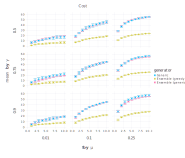

In [71]:
plot_results(cost, title="Cost")

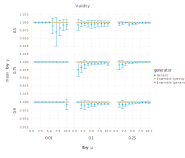

In [70]:
plot_results(validity, title="Validity")